In [1]:
import numpy as np
from utils import set_seed
import torch
from torch.utils.data import DataLoader, TensorDataset
from IB_FactorizedPrior import IB_FactorizedPrior
import importlib
import matplotlib.pyplot as plt

In [ ]:
# Recover datasets from files
data = np.load('../data/mnist_data.npz')
X_train, y_train = data['X_train'], data['y_train']
X_val, y_val = data['X_val'], data['y_val']
X_test, y_test = data['X_test'], data['y_test']
print("Datasets loaded from mnist_data.npz")

set_seed(42)

X_train_tensor = torch.tensor(X_train.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.reshape(-1, 1, 28, 28), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Datasets loaded from mnist_data.npz
Seed set to: 42
Train set: (50000, 784) (50000,)
Validation set: (10000, 784) (10000,)
Test set: (10000, 784) (10000,)


In [13]:
SCALE = 3.0
BETA = 1.0
MODEL = "hybrid_v2"
OPTIMIZER = "Adam"
TRANSFORM = 0.0
DROPOUT = 0.2
FIXED_MEANS = False
TYPE = "best_acc"

In [ ]:
module = importlib.import_module(MODEL)
GeneralFlow = getattr(module, 'GeneralFlow')

prior = IB_FactorizedPrior(total_dim=784, num_classes=10, device=device, scale=SCALE, fixed_means=FIXED_MEANS)
model = GeneralFlow().to(device)

checkpoint = torch.load(f"../experiments/models/ib/{TYPE}_{SCALE}_{BETA}_{MODEL}_{OPTIMIZER}_{TRANSFORM}_{DROPOUT}_{FIXED_MEANS}.pth")
model.load_state_dict(checkpoint['model_state_dict'])
prior.load_state_dict(checkpoint['prior_state_dict'])
prior.means = checkpoint['means']
print (f"Epoch: {checkpoint['epoch']}")

model.eval()
prior.eval()

correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        z, _ = model(batch_X)
        z = z.view(-1, 784)
        preds = prior.classify(z)
        if isinstance(preds, tuple):
            preds = preds[0]
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

val_accuracy = correct / total
print(f"Validation accuracy: {val_accuracy:.4f}")

correct = 0
total = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        z, _ = model(batch_X)
        z = z.view(-1, 784)
        preds = prior.classify(z)
        if isinstance(preds, tuple):
            preds = preds[0]  # Use only the predicted labels
        correct += (preds == batch_y).sum().item()
        total += batch_y.size(0)

test_accuracy = correct / total
print(f"Test accuracy: {test_accuracy:.4f}")

Epoch: 1
Validation accuracy: 0.7276
Test accuracy: 0.7397


Temperature = 0

Seed set to: 42


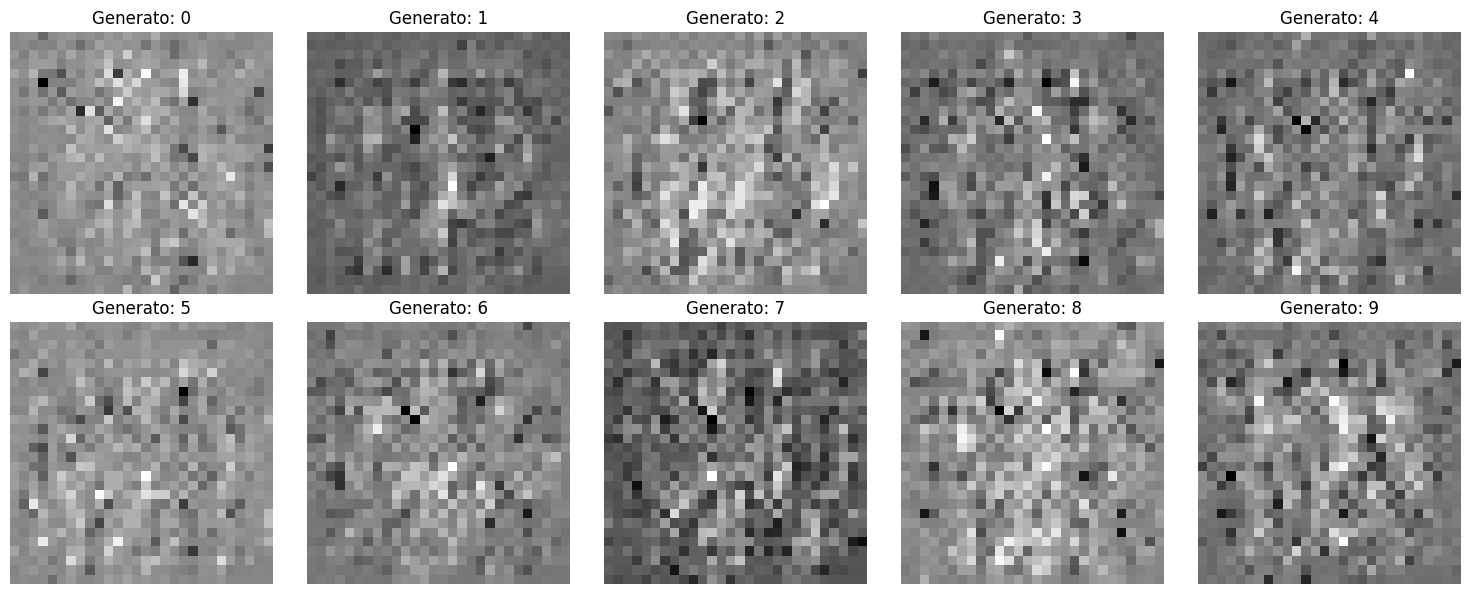

In [12]:
set_seed(42)

model.eval()

targets = list(range(10))
temp = 0

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
with torch.no_grad():
    for idx, target in enumerate(targets):
        z = prior.means[target].unsqueeze(0).to(device) + torch.randn(1, prior.means.shape[1]).to(device) * temp
        z_structural = z.view(1, 4, 14, 14)
        img_gen = model.inverse(z_structural)
        ax = axes[idx // 5, idx % 5]
        ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
        ax.set_title(f"Generato: {target}")
        ax.axis('off')
plt.tight_layout()
plt.show() 

Temperature = 0.25

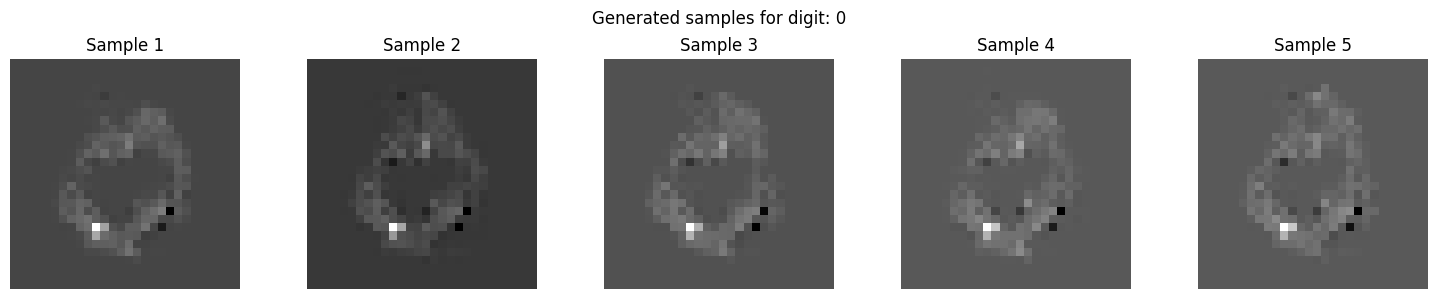

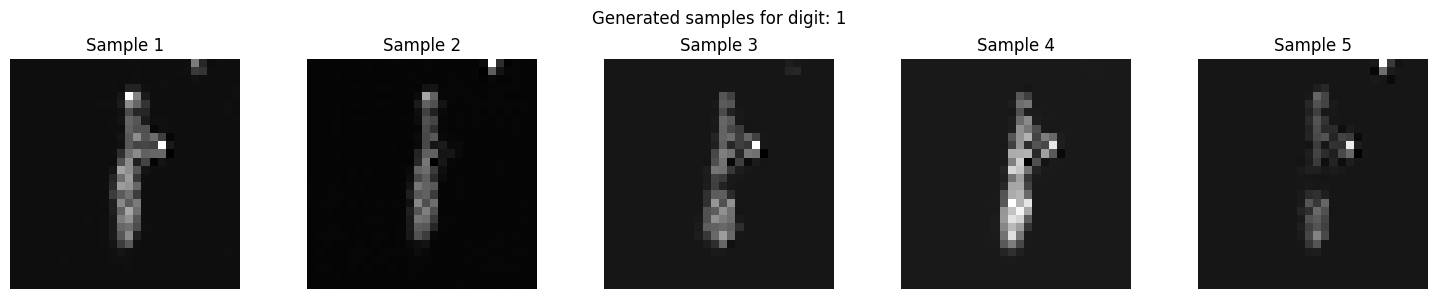

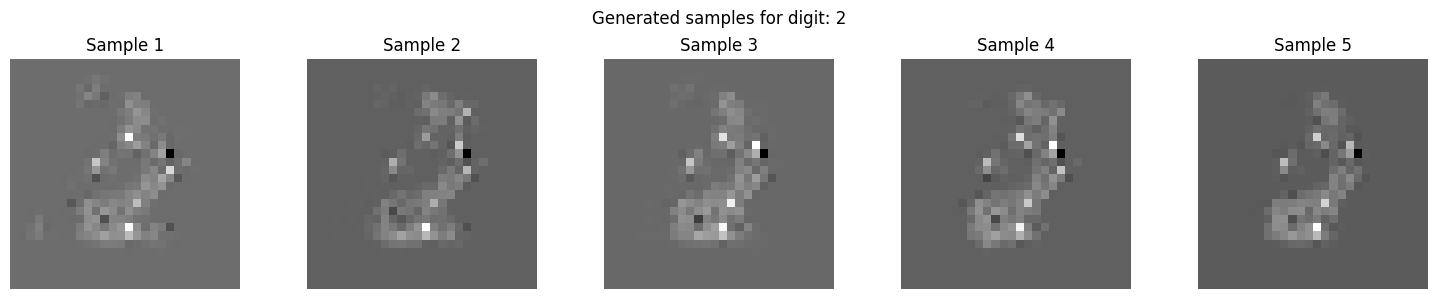

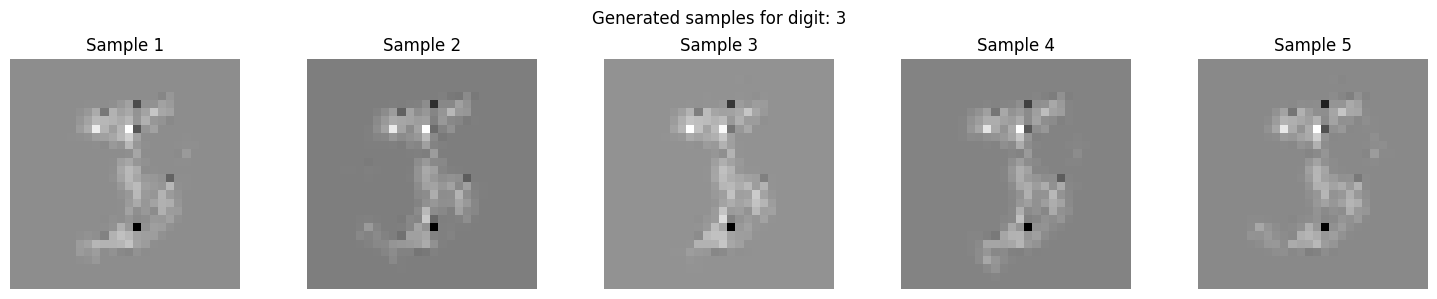

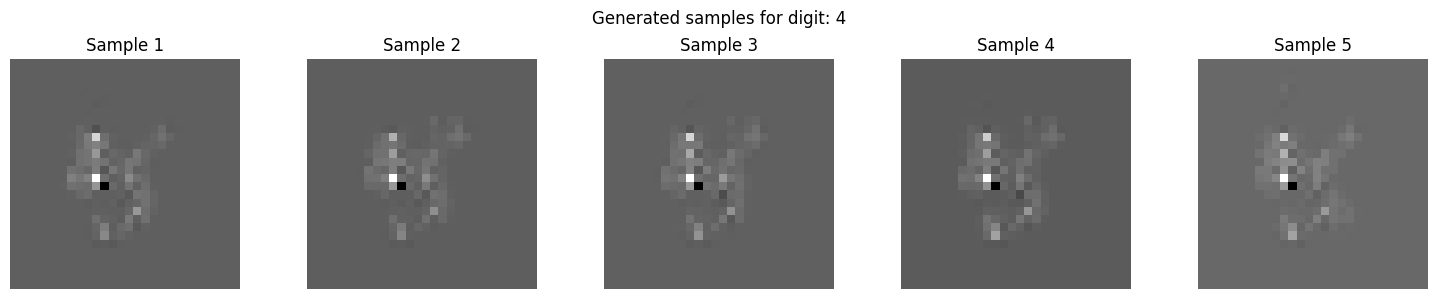

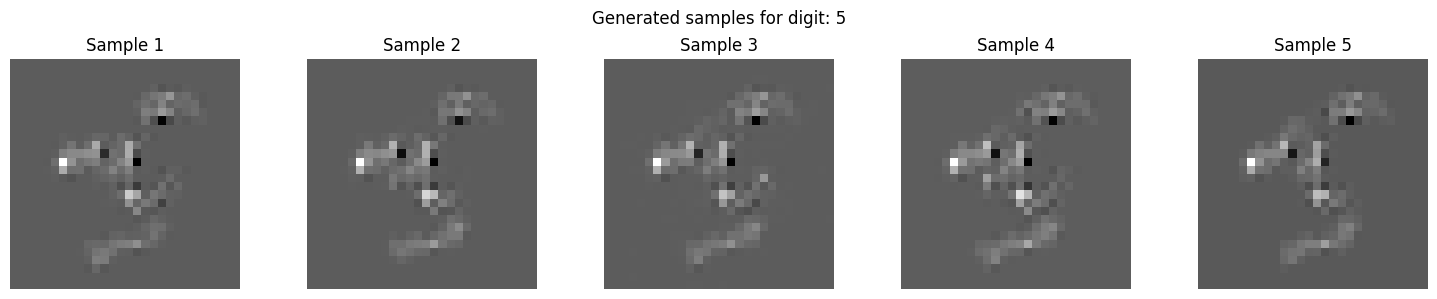

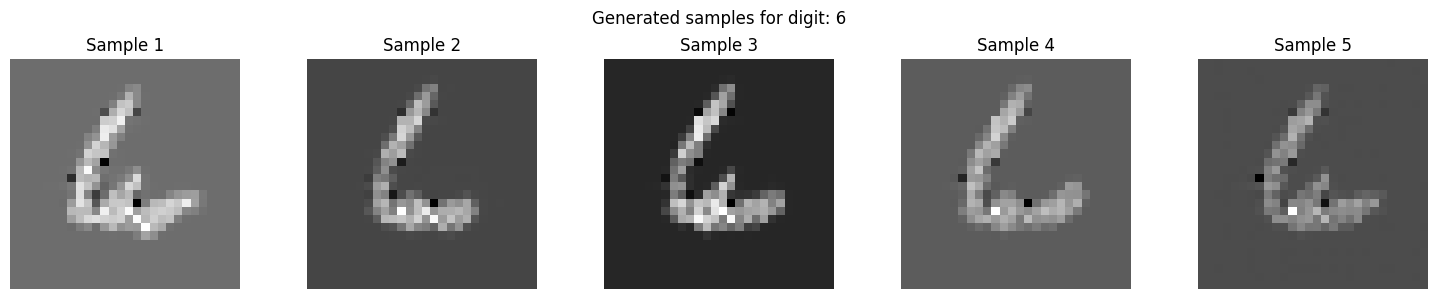

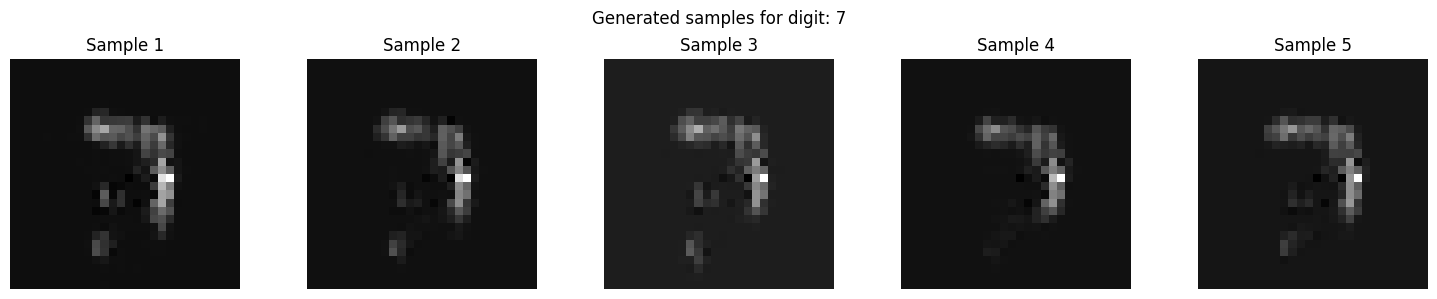

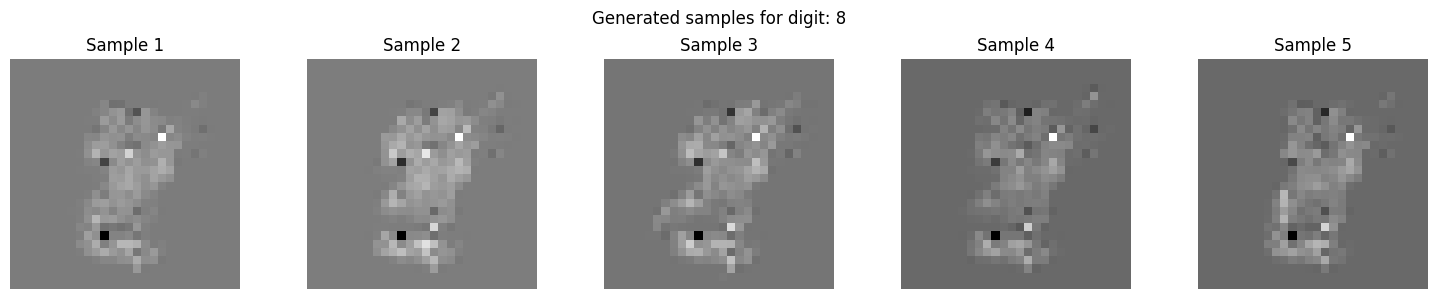

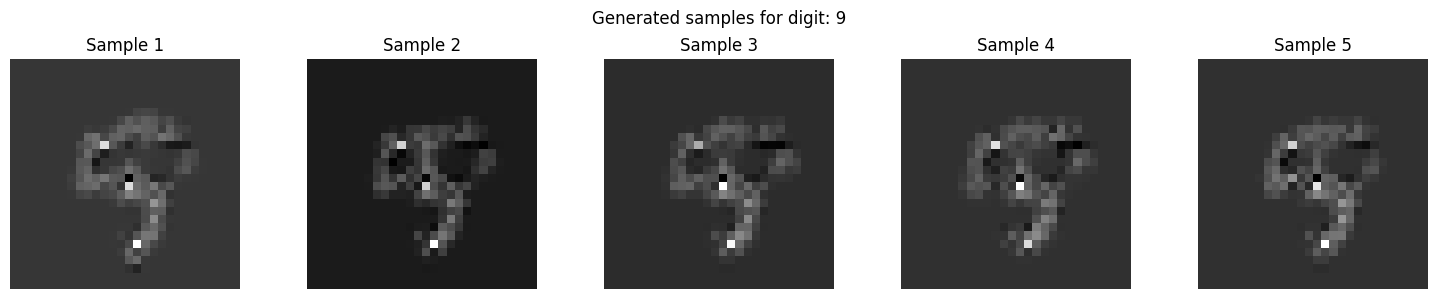

In [22]:
model.eval()

targets = list(range(10))
temp = 0.15

figs = []
with torch.no_grad():
    for target in targets:
        fig, axes = plt.subplots(1, 5, figsize=(15, 3))
        for i in range(5):
            z = prior.means[target].unsqueeze(0).to(device) + torch.randn(1, prior.means.shape[1]).to(device) * temp
            z_structural = z.view(1, 4, 14, 14)
            img_gen = model.inverse(z_structural)
            ax = axes[i]
            ax.imshow(img_gen.squeeze().cpu(), cmap='gray')
            ax.set_title(f"Sample {i+1}")
            ax.axis('off')
        plt.suptitle(f"Generated samples for digit: {target}")
        plt.tight_layout()
        plt.show()
        figs.append(fig)